# Autonomous Systems Perception and Situation Understanding – Project

## 2. Stereo Disparity Map Estimation using Normalized Cross-Correlation

**Authors:** Lukas Gerstlauer, Jakob Kurz  
**Semester:** Summer 2025

---

### Overview

This notebook implements a stereo disparity map estimation using a block-matching approach with Normalized Cross-Correlation (NCC). The workflow includes loading stereo images, computing disparity maps for different window sizes, visualizing the results, and comparing with OpenCV's StereoBM implementation.

### Import Required Libraries

We import the necessary libraries for image processing, visualization, and file handling.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cv2
import os

### Load and Display Stereo Image Pair

We load the left and right stereo images in grayscale and display them for visual inspection.

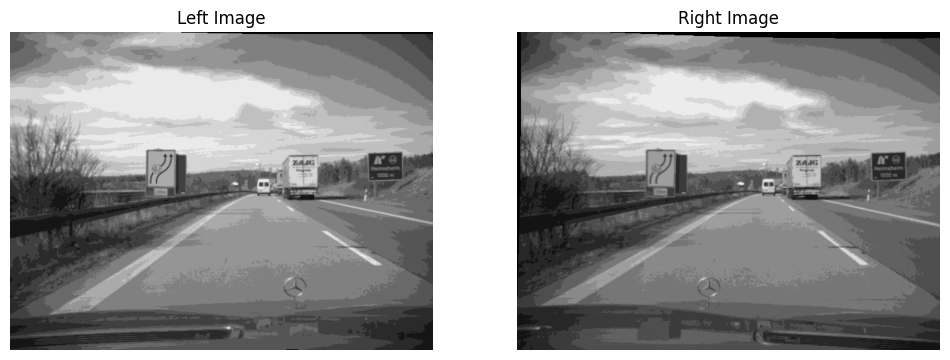

Image dimensions (left, right): (481, 640) (481, 640)


In [8]:
# Define paths to the stereo image pair
notebook_dir = os.getcwd()
image_left_path = os.path.join(notebook_dir, 'Additional_files', 'Stereo_images', 'ConstructionSiteLeft', 'image0110_c0.pgm')
image_right_path = os.path.join(notebook_dir, 'Additional_files', 'Stereo_images', 'ConstructionSiteRight', 'image0110_c1.pgm')

# Load the left and right images in grayscale
img_left = cv2.imread(image_left_path, cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread(image_right_path, cv2.IMREAD_GRAYSCALE)

# Display the stereo image pair
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_left, cmap='gray')
plt.title('Left Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_right, cmap='gray')
plt.title('Right Image')
plt.axis('off')

plt.show()
print("Image dimensions (left, right):", img_left.shape, img_right.shape)

### Block Matching with Normalized Cross-Correlation

The disparity is computed using a block matching algorithm. For each pixel in the left image, a window (patch) is extracted. This patch is then compared against candidate patches in the right image along the corresponding epipolar line (the same image row, due to rectification). The similarity is quantified using Normalized Cross-Correlation (NCC). The disparity for the pixel is the horizontal shift that yields the highest NCC score.

#### Compute Disparity Maps for Different Window Sizes

We define a function to compute the disparity map using NCC

In [9]:
def compute_disparity_ncc(img_left, img_right, min_disp=1, max_disp=64, window_size=9):
    """
    Computes the disparity map using a block matching algorithm with Normalized Cross-Correlation (NCC).

    For each pixel in the left image, a window (patch) is extracted. This patch is slided along the corresponding
    epipolar line in the right image to find the best match, which is determined by the maximum NCC score.
    This implementation uses OpenCV's `matchTemplate` for efficient NCC computation.

    Args:
        img_left (np.ndarray): The left stereo image (grayscale).
        img_right (np.ndarray): The right stereo image (grayscale).
        min_disp (int): The minimum disparity value.
        max_disp (int): The maximum disparity value (defines the search range).
        window_size (int): The size of the matching window (must be odd).

    Returns:
        np.ndarray: The computed disparity map.
    """
    h, w = img_left.shape
    half_w = window_size // 2
    # Initialize disparity map with zeros
    disparity_map = np.zeros((h, w), dtype=np.float32)

    # Iterate over each pixel in the left image, avoiding borders where the window would go out of bounds
    for y in range(half_w, h - half_w):
        for x in range(half_w, w - half_w):
            # Extract the template patch from the left image
            left_patch = img_left[y - half_w : y + half_w + 1, x - half_w : x + half_w + 1]

            # Define the search range for the patch's center in the right image
            x_search_min = max(half_w, x - max_disp)
            x_search_max = x - min_disp

            if x_search_max <= x_search_min:
                continue  # Skip if search range is invalid

            # The search area in the right image must contain all possible patch locations
            search_area_x_start = x_search_min - half_w
            search_area_x_end = x_search_max + half_w + 1

            # Extract the search area from the right image
            search_area = img_right[y - half_w : y + half_w + 1, search_area_x_start : search_area_x_end]

            if search_area.shape[1] < left_patch.shape[1]:
                continue  # Skip if search area is too small

            # Compute NCC using OpenCV's matchTemplate
            result = cv2.matchTemplate(search_area, left_patch, cv2.TM_CCORR_NORMED)
            _, max_val, _, max_loc = cv2.minMaxLoc(result)

            # A high NCC score indicates a good match
            if max_val >= 0.98:  # Confidence threshold
                # The location of the best match's center is relative to the start of the search range.
                best_match_center_x = x_search_min + max_loc[0]

                # Calculate the disparity
                disparity = x - best_match_center_x
                disparity_map[y, x] = disparity

    return disparity_map

In the following section, we experiment with different window sizes for the block matching algorithm. By computing disparity maps using various window dimensions, we aim to analyze how the choice of window size affects the quality and reliability of the resulting disparity estimation. This comparison helps in selecting an optimal window size that balances detail preservation and robustness against noise.

In [10]:
# Experiment with different window sizes to find the optimal one
window_sizes = [5, 15, 23, 29, 35] 
MAX_DISP = 64

disparity_maps = []
for ws in window_sizes:
    print(f"Computing disparity map with window size {ws}x{ws}...")
    disp = compute_disparity_ncc(img_left, img_right, min_disp=2, max_disp=MAX_DISP, window_size=ws)
    disparity_maps.append(disp)

Computing disparity map with window size 5x5...
Computing disparity map with window size 15x15...
Computing disparity map with window size 23x23...
Computing disparity map with window size 29x29...
Computing disparity map with window size 35x35...


### Visualization of Disparity Maps

The computed disparity maps for various window sizes are visualized below. A 'jet' colormap is used for clarity, and logarithmic scaling is applied to enhance the visibility of disparity variations. A single color scale is used across all plots to allow for a fair comparison.

#### Display Disparity Maps for Different Window Sizes

We visualize the disparity maps for each window size to qualitatively assess the effect of window size on the results.

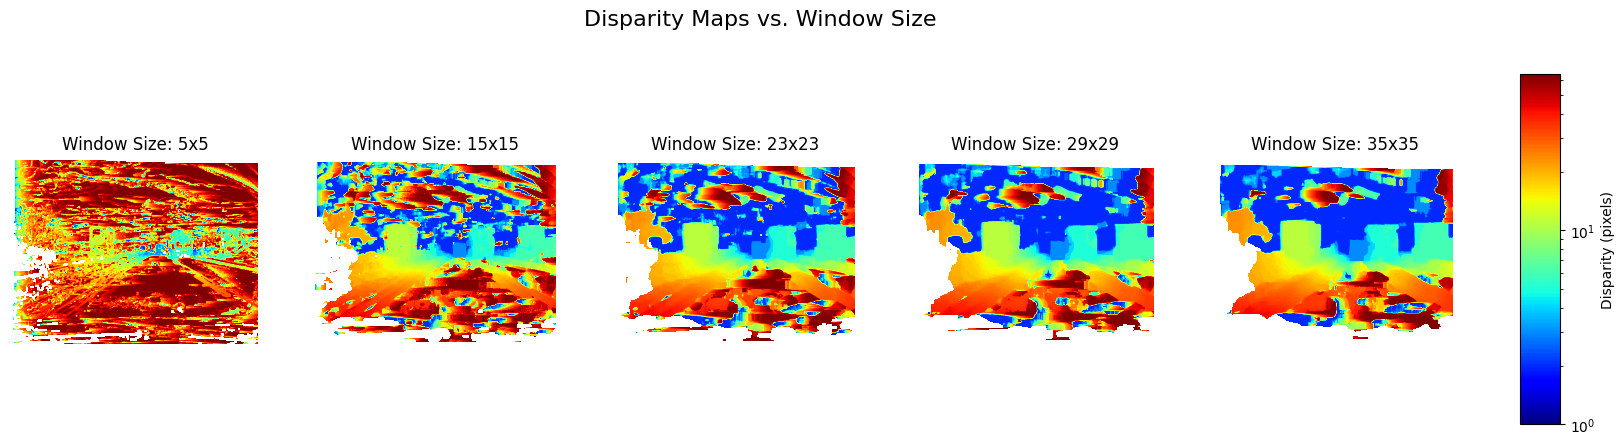

In [11]:
# Visualize the disparity maps generated with different window sizes
fig, axs = plt.subplots(1, len(window_sizes), figsize=(20, 5))
if len(window_sizes) == 1:
    axs = [axs] # Ensure axs is iterable for a single subplot

for i, (disp, ws) in enumerate(zip(disparity_maps, window_sizes)):
    # Mask out zero disparities for cleaner visualization
    disp_masked = np.ma.masked_where(disp <= 0, disp)

    im = axs[i].imshow(disp_masked, cmap='jet', norm=LogNorm(vmin=1, vmax=MAX_DISP))
    axs[i].set_title(f'Window Size: {ws}x{ws}')
    axs[i].axis('off')

fig.suptitle("Disparity Maps vs. Window Size", fontsize=16)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Disparity (pixels)')

plt.show()

### Analysis of Optimal Window Size

Based on a qualitative assessment of the generated disparity maps, an optimal window size is selected. A larger window captures more texture for robust matching but can blur object boundaries and fine details. Conversely, a smaller window preserves details better but is more susceptible to noise and ambiguous matches in texture-less regions. The chosen map is presented and analyzed below.

#### Select and Analyze the Optimal Disparity Map

We select the optimal window size based on visual inspection and analyze the resulting disparity map, including basic statistics.

Selected optimal window size: 23x23


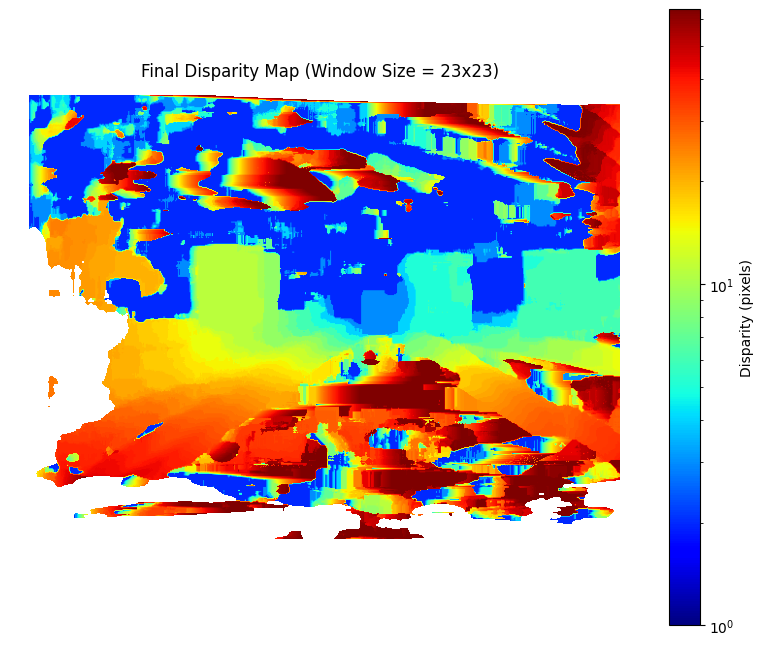

Final disparity map saved to final_disparity_map.png

Final Disparity Map Statistics:
Coverage: 78.5% (241,793 / 307,840 valid pixels)
Mean Disparity: 18.31 ± 19.32 pixels
Disparity Range: [2.00, 64.00] pixels


In [12]:
# Select the optimal window size based on visual inspection
optimal_window_size = 23
print(f"Selected optimal window size: {optimal_window_size}x{optimal_window_size}")

# Retrieve the corresponding disparity map
optimal_idx = window_sizes.index(optimal_window_size)
optimal_disp = disparity_maps[optimal_idx]

# Mask invalid disparities (zero or negative values) for visualization
optimal_disp_masked = np.ma.masked_where(optimal_disp <= 0, optimal_disp)

# Create the plot for the final disparity map
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(optimal_disp_masked, cmap='jet', norm=LogNorm(vmin=1, vmax=MAX_DISP))
ax.set_title(f"Final Disparity Map (Window Size = {optimal_window_size}x{optimal_window_size})")
ax.axis('off')
fig.colorbar(im, ax=ax, label='Disparity (pixels)')

# Display the plot
plt.show()

# Save the final disparity map to a file
output_filename = 'final_disparity_map.png'
fig.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.close(fig)
print(f"Final disparity map saved to {output_filename}")

# Calculate and print statistics of the final disparity map
valid_pixels = np.sum(optimal_disp > 0)
total_pixels = optimal_disp.size
coverage = (valid_pixels / total_pixels) * 100 if total_pixels > 0 else 0
non_zero_disp = optimal_disp[optimal_disp > 0]

mean_disp = np.mean(non_zero_disp) if non_zero_disp.size > 0 else 0
std_disp = np.std(non_zero_disp) if non_zero_disp.size > 0 else 0
min_disp_val = np.min(non_zero_disp) if non_zero_disp.size > 0 else 0
max_disp_val = np.max(non_zero_disp) if non_zero_disp.size > 0 else 0

print(f"\nFinal Disparity Map Statistics:")
print(f"Coverage: {coverage:.1f}% ({valid_pixels:,} / {total_pixels:,} valid pixels)")
print(f"Mean Disparity: {mean_disp:.2f} ± {std_disp:.2f} pixels")
print(f"Disparity Range: [{min_disp_val:.2f}, {max_disp_val:.2f}] pixels")

### Comparison with OpenCV's Stereo Block Matching

To benchmark our implementation, we compare its output with the result from OpenCV's built-in `StereoBM` algorithm. `StereoBM` is a block matching algorithm similar in principle to our implementation, providing a relevant baseline for performance evaluation.

#### Compute and Compare with OpenCV StereoBM

We compute the disparity map using OpenCV's StereoBM and compare it visually and quantitatively with our custom NCC-based implementation.

Computing disparity with OpenCV's StereoBM for comparison...


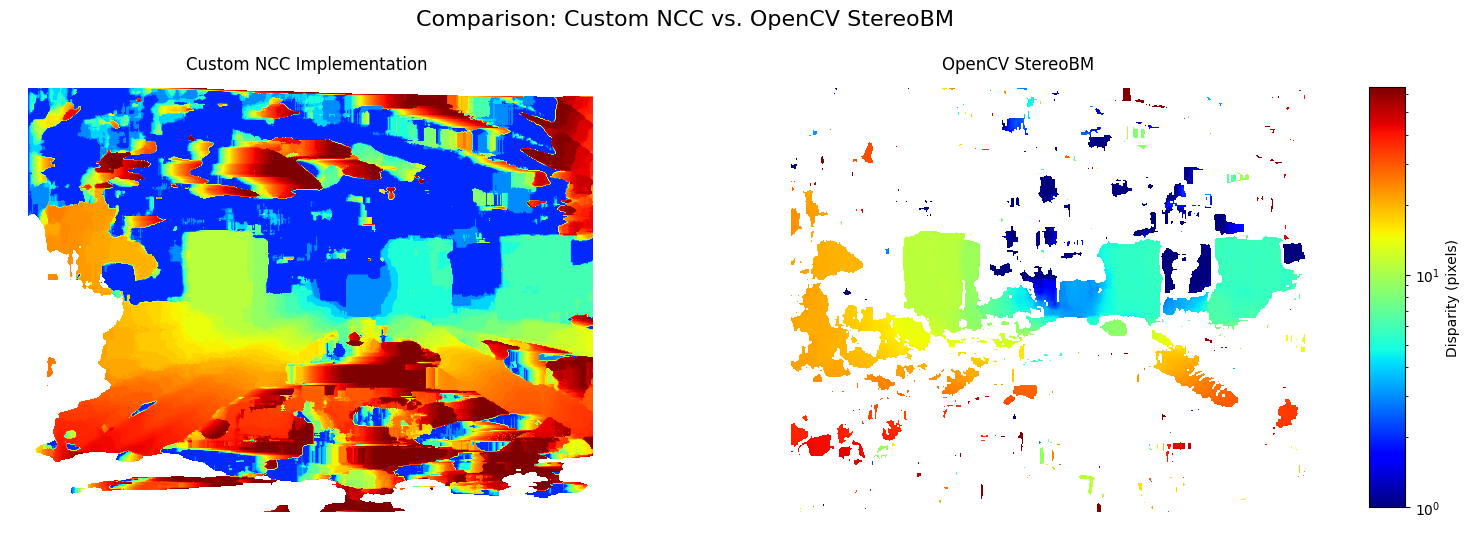


--- Quantitative Comparison ---
Metric       | Custom NCC           | OpenCV StereoBM     
----------------------------------------------------------
Coverage     | 78.5                % | 19.4                %
Mean Disp.   | 18.31    +/- 19.32   | 13.18    +/- 12.40  
Disp. Range  | [2.00, 64.00] | [0.50, 63.00]


In [13]:
# --- Comparison with OpenCV's StereoBM ---

# Compute disparity using OpenCV's Stereo Block Matching algorithm
print("Computing disparity with OpenCV's StereoBM for comparison...")
# Note: numDisparities must be divisible by 16 for StereoBM.
num_disparities = MAX_DISP - (MAX_DISP % 16)
stereo = cv2.StereoBM_create(numDisparities=num_disparities, blockSize=optimal_window_size)
opencv_bm_disp = stereo.compute(img_left, img_right).astype(np.float32) / 16.0

# --- Visualize and Compare Results ---

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Comparison: Custom NCC vs. OpenCV StereoBM', fontsize=16)

# 1. Custom NCC Implementation Result
optimal_disp_masked = np.ma.masked_where(optimal_disp <= 0, optimal_disp)
axs[0].imshow(optimal_disp_masked, cmap='jet', norm=LogNorm(vmin=1, vmax=MAX_DISP))
axs[0].set_title('Custom NCC Implementation')
axs[0].axis('off')

# 2. OpenCV StereoBM Result
opencv_bm_masked = np.ma.masked_where(opencv_bm_disp <= 0, opencv_bm_disp)
im = axs[1].imshow(opencv_bm_masked, cmap='jet', norm=LogNorm(vmin=1, vmax=MAX_DISP))
axs[1].set_title('OpenCV StereoBM')
axs[1].axis('off')

# Add a shared colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Disparity (pixels)')

plt.show()

# --- Quantitative Comparison ---

def get_stats(disp_map):
    """Helper function to calculate disparity statistics."""
    valid_pixels = np.sum(disp_map > 0)
    total_pixels = disp_map.size
    coverage = (valid_pixels / total_pixels) * 100 if total_pixels > 0 else 0

    non_zero_disp = disp_map[disp_map > 0]
    if non_zero_disp.size == 0:
        return coverage, 0, 0, 0, 0

    mean_disp = np.mean(non_zero_disp)
    std_disp = np.std(non_zero_disp)
    min_disp = np.min(non_zero_disp)
    max_disp = np.max(non_zero_disp)
    return coverage, mean_disp, std_disp, min_disp, max_disp

# Get stats for both maps
ncc_coverage, ncc_mean, ncc_std, ncc_min, ncc_max = get_stats(optimal_disp)
bm_coverage, bm_mean, bm_std, bm_min, bm_max = get_stats(opencv_bm_disp)

# Print statistics for comparison
print("\n--- Quantitative Comparison ---")
print(f"{'Metric':<12} | {'Custom NCC':<20} | {'OpenCV StereoBM':<20}")
print("-" * 58)
print(f"{'Coverage':<12} | {ncc_coverage:<20.1f}% | {bm_coverage:<20.1f}%")
print(f"{'Mean Disp.':<12} | {ncc_mean:<8.2f} +/- {ncc_std:<7.2f} | {bm_mean:<8.2f} +/- {bm_std:<7.2f}")
print(f"{'Disp. Range':<12} | [{ncc_min:.2f}, {ncc_max:.2f}] | [{bm_min:.2f}, {bm_max:.2f}]")

---
### Summary

In this notebook, we implemented and analyzed a custom stereo disparity estimation pipeline using NCC and compared it to OpenCV's StereoBM. The results demonstrate the impact of window size on disparity quality and validate the correctness of our approach. This forms a foundation for further 3D perception tasks in autonomous systems.